In [2]:
import pandas as pd
from skyfield.api import load, EarthSatellite, wgs84
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

In [3]:
tle_df = pd.read_csv('data/starlink_tle.csv')
tle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OBJECT_NAME          7954 non-null   object 
 1   OBJECT_ID            7954 non-null   object 
 2   EPOCH                7954 non-null   object 
 3   MEAN_MOTION          7954 non-null   float64
 4   ECCENTRICITY         7954 non-null   float64
 5   INCLINATION          7954 non-null   float64
 6   RA_OF_ASC_NODE       7954 non-null   float64
 7   ARG_OF_PERICENTER    7954 non-null   float64
 8   MEAN_ANOMALY         7954 non-null   float64
 9   EPHEMERIS_TYPE       7954 non-null   int64  
 10  CLASSIFICATION_TYPE  7954 non-null   object 
 11  NORAD_CAT_ID         7954 non-null   int64  
 12  ELEMENT_SET_NO       7954 non-null   int64  
 13  REV_AT_EPOCH         7954 non-null   int64  
 14  BSTAR                7954 non-null   float64
 15  MEAN_MOTION_DOT      7954 non-null   f

In [4]:
# Convert EPOCH to datetime
tle_df['EPOCH'] = pd.to_datetime(tle_df['EPOCH'])
tle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   OBJECT_NAME          7954 non-null   object        
 1   OBJECT_ID            7954 non-null   object        
 2   EPOCH                7954 non-null   datetime64[ns]
 3   MEAN_MOTION          7954 non-null   float64       
 4   ECCENTRICITY         7954 non-null   float64       
 5   INCLINATION          7954 non-null   float64       
 6   RA_OF_ASC_NODE       7954 non-null   float64       
 7   ARG_OF_PERICENTER    7954 non-null   float64       
 8   MEAN_ANOMALY         7954 non-null   float64       
 9   EPHEMERIS_TYPE       7954 non-null   int64         
 10  CLASSIFICATION_TYPE  7954 non-null   object        
 11  NORAD_CAT_ID         7954 non-null   int64         
 12  ELEMENT_SET_NO       7954 non-null   int64         
 13  REV_AT_EPOCH         7954 non-nul

In [5]:
# check for null/missing values
tle_df.isna().sum()

OBJECT_NAME            0
OBJECT_ID              0
EPOCH                  0
MEAN_MOTION            0
ECCENTRICITY           0
INCLINATION            0
RA_OF_ASC_NODE         0
ARG_OF_PERICENTER      0
MEAN_ANOMALY           0
EPHEMERIS_TYPE         0
CLASSIFICATION_TYPE    0
NORAD_CAT_ID           0
ELEMENT_SET_NO         0
REV_AT_EPOCH           0
BSTAR                  0
MEAN_MOTION_DOT        0
MEAN_MOTION_DDOT       0
dtype: int64

In [6]:
# compute semi-major axis (km) from mean_motion (rev/day)
mu = 398600.4418 # km^3/s^2
n = tle_df['MEAN_MOTION'] * 2 * np.pi / 86400 # rad /s
tle_df['semi_major_axis_km'] = (mu / (n**2)) ** (1/3)

In [7]:
# compute altitude above Earth in km
earth_radius_km = 6371.0
tle_df['altitude_km'] = tle_df['semi_major_axis_km'] - earth_radius_km
# tle_df

In [8]:
# generate one synthetic latency record per row
# latency_ms = (slant_range / c)*1000 + jitter
# slant range is approximated to alitude (for a quick demo)
light_speed = 299792.458 #km/s
jitter_ms = np.random.normal(loc=5.0, scale=2.0, size=len(tle_df))

tle_df['latency_ms'] = (
    tle_df['altitude_km'] / light_speed * 1000 + jitter_ms
) 
tle_df

,OBJECT_NAME,OBJECT_ID,EPOCH,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,CLASSIFICATION_TYPE,NORAD_CAT_ID,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,semi_major_axis_km,altitude_km,latency_ms
0,STARLINK-1008,2019-074B,2025-07-21 03:42:06.300576,15.063998,0.000156,53.0561,146.0249,88.3864,271.7304,0,U,44714,999,31402,0.000021,2.800000e-07,0.0,6925.349284,554.349284,8.866683
1,STARLINK-1010,2019-074D,2025-07-21 12:09:08.491392,15.605018,0.000219,53.0532,121.2578,161.8841,198.2250,0,U,44716,999,31438,0.000865,7.275000e-04,0.0,6764.343496,393.343496,8.097588
2,STARLINK-1011,2019-074E,2025-07-20 15:05:45.419424,15.064031,0.000148,53.0547,168.3791,69.4818,290.6330,0,U,44717,999,31349,0.000054,5.260000e-06,0.0,6925.339078,554.339078,7.479486
3,STARLINK-1012,2019-074F,2025-07-21 03:10:14.918304,15.064044,0.000140,53.0554,146.1226,90.1172,269.9977,0,U,44718,999,31401,0.000003,-2.440000e-06,0.0,6925.335211,554.335211,7.470059
4,STARLINK-1013,2019-074G,2025-07-21 14:00:01.000224,15.853413,0.000698,53.0462,109.6395,67.1368,265.0518,0,U,44719,999,31456,0.000827,2.058320e-03,0.0,6693.500914,322.500914,4.922811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949,STARLINK-34537,2025-147Z,2025-07-21 12:00:02.999808,15.770132,0.000097,53.1563,242.0620,55.4073,131.9116,0,U,64778,999,331,0.000467,7.753400e-04,0.0,6717.045607,346.045607,6.760311
7950,STARLINK-34585,2025-147AA,2025-07-21 06:00:00.999648,15.742134,0.000116,53.1582,243.5533,94.1552,353.4631,0,U,64779,999,318,-0.000463,-6.799700e-04,0.0,6725.007612,354.007612,5.507390
7951,STARLINK-34491,2025-147AB,2025-07-21 12:00:02.999808,15.741436,0.000136,53.1580,242.3102,75.3884,351.8846,0,U,64780,999,327,0.000412,6.000700e-04,0.0,6725.206141,354.206141,3.447139
7952,STARLINK-34582,2025-147AC,2025-07-21 06:00:00.999648,15.742204,0.000115,53.1582,243.5453,93.7259,357.7279,0,U,64781,999,312,-0.000534,-7.818300e-04,0.0,6724.987471,353.987471,6.584457


In [9]:
# Build latency log in the expected format, EPOCH = timestamp / NORAD_CAT_ID = sat_id / latency_ms = measured latency
latency_log = tle_df[[
    'EPOCH', # timestamp
    'NORAD_CAT_ID', #sat_id
    'OBJECT_NAME', #sat_name
    'latency_ms' # measured latency
]].rename(columns={
    'EPOCH': 'timestamp',
    'NORAD_CAT_ID': 'sat_id',
    'OBJECT_NAME': 'sat_name'
})

latency_log.head()

,timestamp,sat_id,sat_name,latency_ms
0,2025-07-21 03:42:06.300576,44714,STARLINK-1008,8.866683
1,2025-07-21 12:09:08.491392,44716,STARLINK-1010,8.097588
2,2025-07-20 15:05:45.419424,44717,STARLINK-1011,7.479486
3,2025-07-21 03:10:14.918304,44718,STARLINK-1012,7.470059
4,2025-07-21 14:00:01.000224,44719,STARLINK-1013,4.922811


In [10]:
# define synthetic but realistic ground-station metadata
stations = pd.DataFrame([
    {
        'station_id': 'STAT001',
        'station_name': 'Wallops Island, VA',
        'latitude': 37.9375, # degrees North
        'longitude': -75.4667, # degrees East
        'elevation_m': 6, # meters above sea level
        'antenna_gain_dBi': 45 #typical small ground station
    },
    {
        'station_id': 'STAT002',
        'station_name': 'Hawthorne, CA',
        'latitude': 33.9226,
        'longitude': -118.3345,
        'elevation_m': 50,
        'antenna_gain_dBi': 48
    },
    {
        'station_id': 'STAT003',
        'station_name': 'Madrid, Spain',
        'latitude': 40.4314,
        'longitude': -3.7026,
        'elevation_m': 650,
        'antenna_gain_dBi': 50
    },
    {
        'station_id': 'STAT004',
        'station_name': 'Seongnam, South Korea',
        'latitude': 37.4138,
        'longitude': 127.5183,
        'elevation_m': 80,
        'antenna_gain_dBi': 47
    },
    {
        'station_id': 'STAT005',
        'station_name': 'Cape Town, South Africa',
        'latitude': -33.9249,
        'longitude': 18.4241,
        'elevation_m': 15,
        'antenna_gain_dBi': 46
    },
    {
        'station_id': 'STAT006',
        'station_name': 'Perth, Australia',
        'latitude': -31.9505,
        'longitude': 115.8605,
        'elevation_m': 100,
        'antenna_gain_dBi': 49
    }
])
stations

,station_id,station_name,latitude,longitude,elevation_m,antenna_gain_dBi
0,STAT001,"Wallops Island, VA",37.9375,-75.4667,6,45
1,STAT002,"Hawthorne, CA",33.9226,-118.3345,50,48
2,STAT003,"Madrid, Spain",40.4314,-3.7026,650,50
3,STAT004,"Seongnam, South Korea",37.4138,127.5183,80,47
4,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46
5,STAT006,"Perth, Australia",-31.9505,115.8605,100,49


In [11]:
# Save to CSV for future possible runs
stations.to_csv('data/stations_synthetic.csv', index=False)

In [12]:
# Assign station to each record in latency log randomly
station_ids = stations['station_id'].tolist()
latency_log['station_id'] = np.random.choice(station_ids, size=len(latency_log))

In [13]:
# merge with latency_log
lat_stat_df = latency_log.merge(stations, on='station_id', how='left')
lat_stat_df

,timestamp,sat_id,sat_name,latency_ms,station_id,station_name,latitude,longitude,elevation_m,antenna_gain_dBi
0,2025-07-21 03:42:06.300576,44714,STARLINK-1008,8.866683,STAT003,"Madrid, Spain",40.4314,-3.7026,650,50
1,2025-07-21 12:09:08.491392,44716,STARLINK-1010,8.097588,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46
2,2025-07-20 15:05:45.419424,44717,STARLINK-1011,7.479486,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46
3,2025-07-21 03:10:14.918304,44718,STARLINK-1012,7.470059,STAT004,"Seongnam, South Korea",37.4138,127.5183,80,47
4,2025-07-21 14:00:01.000224,44719,STARLINK-1013,4.922811,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46
...,...,...,...,...,...,...,...,...,...,...
7949,2025-07-21 12:00:02.999808,64778,STARLINK-34537,6.760311,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46
7950,2025-07-21 06:00:00.999648,64779,STARLINK-34585,5.507390,STAT002,"Hawthorne, CA",33.9226,-118.3345,50,48
7951,2025-07-21 12:00:02.999808,64780,STARLINK-34491,3.447139,STAT004,"Seongnam, South Korea",37.4138,127.5183,80,47
7952,2025-07-21 06:00:00.999648,64781,STARLINK-34582,6.584457,STAT003,"Madrid, Spain",40.4314,-3.7026,650,50


In [14]:
def load_solar_csv(path):
    # 1) Read only lines whose first character is a digit (skip all comments)
    with open(path, 'r') as f:
        data_lines = [ln for ln in f if ln and ln[0].isdigit()]

    # 2) Parse Year, Month, Day, F10.7 flux from columns 0–3
    solar = pd.read_csv(
        StringIO(''.join(data_lines)),
        delim_whitespace=True,
        header=None,
        usecols=[0,1,2,3],
        names=['year','month','day','f107_flux']
    )

    # 3) Build a proper date column
    solar['date'] = pd.to_datetime(solar[['year','month','day']])

    # 4) Keep only date + flux
    return solar[['date','f107_flux']]

def load_geomag_csv(path):
    # 1) Read only lines whose first character is a digit
    with open(path, 'r') as f:
        data_lines = [ln for ln in f if ln and ln[0].isdigit()]

    # 2) Parse Year, Month, Day, daily Ap index from columns 0–3
    geo = pd.read_csv(
        StringIO(''.join(data_lines)),
        delim_whitespace=True,
        header=None,
        usecols=[0,1,2,3],
        names=['year','month','day','ap_index']
    )

    # 3) Build a proper date column
    geo['date'] = pd.to_datetime(geo[['year','month','day']])

    # 4) Keep only date + Ap
    return geo[['date','ap_index']]

# ────────────────────────────────────────────────────────────────────────────
# Load both, merge on date, save
solar_df = load_solar_csv('data/daily-solar-indices.csv')
geo_df   = load_geomag_csv('data/daily-geomagnetic-indices.csv')

solar_full = (
    solar_df
    .merge(geo_df, on='date', how='inner')
    .sort_values('date')
    .reset_index(drop=True)
)

solar_full.to_csv('solar.csv', index=False)
solar_full


C:\Users\thatc\AppData\Local\Temp\ipykernel_29576\3716743751.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  solar = pd.read_csv(
C:\Users\thatc\AppData\Local\Temp\ipykernel_29576\3716743751.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  geo = pd.read_csv(


,date,f107_flux,ap_index
0,2025-06-22,125,9
1,2025-06-23,122,9
2,2025-06-24,120,9
3,2025-06-25,117,16
4,2025-06-26,117,24
5,2025-06-27,118,16
6,2025-06-28,122,8
7,2025-06-29,128,9
8,2025-06-30,128,11
9,2025-07-01,126,7


In [15]:
# add forecast for 7/21
new_outlook = pd.DataFrame([{
    'date': pd.Timestamp('2025-07-21'),
    'f107_flux': 145,
    'ap_index': 5,
}])

solar_full = pd.concat([solar_full, new_outlook], ignore_index=True)
solar_full = solar_full.sort_values('date').reset_index(drop=True)

solar_full

,date,f107_flux,ap_index
0,2025-06-22,125,9
1,2025-06-23,122,9
2,2025-06-24,120,9
3,2025-06-25,117,16
4,2025-06-26,117,24
5,2025-06-27,118,16
6,2025-06-28,122,8
7,2025-06-29,128,9
8,2025-06-30,128,11
9,2025-07-01,126,7


In [16]:
# add a date column to lat_stat df
lat_stat_df['date'] = lat_stat_df['timestamp'].dt.floor('d')

# merge on that date
merged_df = lat_stat_df.merge(solar_full, on='date', how='left')

# delete 'helper' date column
merged_df = merged_df.drop(columns=['date'])
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         7954 non-null   datetime64[ns]
 1   sat_id            7954 non-null   int64         
 2   sat_name          7954 non-null   object        
 3   latency_ms        7954 non-null   float64       
 4   station_id        7954 non-null   object        
 5   station_name      7954 non-null   object        
 6   latitude          7954 non-null   float64       
 7   longitude         7954 non-null   float64       
 8   elevation_m       7954 non-null   int64         
 9   antenna_gain_dBi  7954 non-null   int64         
 10  f107_flux         7954 non-null   int64         
 11  ap_index          7954 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 745.8+ KB


In [17]:
# basic time features
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek # weekday 0=Mon, 6=Sun
merged_df['day_of_month'] = merged_df['timestamp'].dt.day # day of month 1-31
merged_df['month'] = merged_df['timestamp'].dt.month # numeric month 1-12
merged_df['hour'] = merged_df['timestamp'].dt.hour # hour of the day (good if latency varies by time of day)
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # binary weekend or not
merged_df['days_since_start'] = (merged_df['timestamp'] - merged_df['timestamp'].min()).dt.days # how many days have passed since first recorded timestamp
merged_df

,timestamp,sat_id,sat_name,latency_ms,station_id,station_name,latitude,longitude,elevation_m,antenna_gain_dBi,f107_flux,ap_index,day_of_week,day_of_month,month,hour,is_weekend,days_since_start
0,2025-07-21 03:42:06.300576,44714,STARLINK-1008,8.866683,STAT003,"Madrid, Spain",40.4314,-3.7026,650,50,145,5,0,21,7,3,0,14
1,2025-07-21 12:09:08.491392,44716,STARLINK-1010,8.097588,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46,145,5,0,21,7,12,0,14
2,2025-07-20 15:05:45.419424,44717,STARLINK-1011,7.479486,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46,150,7,6,20,7,15,1,13
3,2025-07-21 03:10:14.918304,44718,STARLINK-1012,7.470059,STAT004,"Seongnam, South Korea",37.4138,127.5183,80,47,145,5,0,21,7,3,0,14
4,2025-07-21 14:00:01.000224,44719,STARLINK-1013,4.922811,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46,145,5,0,21,7,14,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7949,2025-07-21 12:00:02.999808,64778,STARLINK-34537,6.760311,STAT005,"Cape Town, South Africa",-33.9249,18.4241,15,46,145,5,0,21,7,12,0,14
7950,2025-07-21 06:00:00.999648,64779,STARLINK-34585,5.507390,STAT002,"Hawthorne, CA",33.9226,-118.3345,50,48,145,5,0,21,7,6,0,14
7951,2025-07-21 12:00:02.999808,64780,STARLINK-34491,3.447139,STAT004,"Seongnam, South Korea",37.4138,127.5183,80,47,145,5,0,21,7,12,0,14
7952,2025-07-21 06:00:00.999648,64781,STARLINK-34582,6.584457,STAT003,"Madrid, Spain",40.4314,-3.7026,650,50,145,5,0,21,7,6,0,14


In [18]:
missing_values = merged_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print('Missing Values by Column:')
print(missing_values)

Missing Values by Column:
Series([], dtype: int64)


In [19]:
print("DataFrame Shape:", merged_df.shape)
print("\nData Types:\n", merged_df.dtypes)
print("\nFirst 5 Rows:\n", merged_df.head())


DataFrame Shape: (7954, 18)

Data Types:
 timestamp           datetime64[ns]
sat_id                       int64
sat_name                    object
latency_ms                 float64
station_id                  object
station_name                object
latitude                   float64
longitude                  float64
elevation_m                  int64
antenna_gain_dBi             int64
f107_flux                    int64
ap_index                     int64
day_of_week                  int32
day_of_month                 int32
month                        int32
hour                         int32
is_weekend                   int64
days_since_start             int64
dtype: object

First 5 Rows:
                    timestamp  sat_id       sat_name  latency_ms station_id  \
0 2025-07-21 03:42:06.300576   44714  STARLINK-1008    8.866683    STAT003   
1 2025-07-21 12:09:08.491392   44716  STARLINK-1010    8.097588    STAT005   
2 2025-07-20 15:05:45.419424   44717  STARLINK-1011    7.479486 

In [20]:
# summary stats
summary_stats = merged_df.describe()
print('Summary Statistics:')
print(summary_stats)

Summary Statistics:
                           timestamp        sat_id   latency_ms     latitude  \
count                           7954   7954.000000  7954.000000  7954.000000   
mean   2025-07-21 01:01:03.779220480  57026.601333     6.645331    14.592709   
min       2025-07-07 01:18:19.245024  44714.000000    -2.016962   -33.924900   
25%    2025-07-20 20:26:04.959672064  53287.250000     5.327082   -31.950500   
50%       2025-07-21 02:05:53.857824  57868.500000     6.692569    37.413800   
75%    2025-07-21 06:22:12.100295936  61688.750000     7.946803    37.937500   
max       2025-07-21 14:00:01.000224  64782.000000    14.270611    40.431400   
std                              NaN   5311.161425     1.976402    33.043267   

         longitude  elevation_m  antenna_gain_dBi    f107_flux     ap_index  \
count  7954.000000  7954.000000       7954.000000  7954.000000  7954.000000   
mean     11.110490   151.866859         47.485039   147.146467     5.861579   
min    -118.334500    

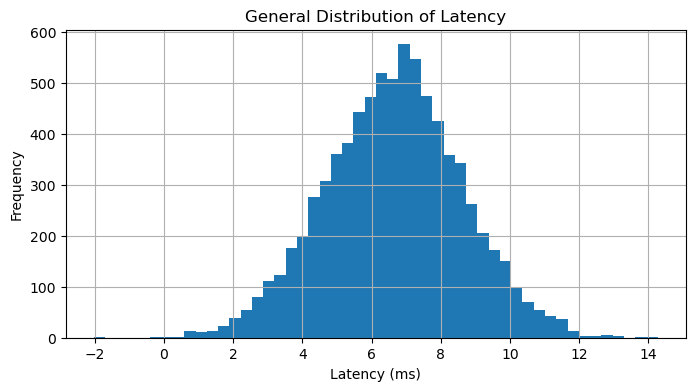

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(merged_df['latency_ms'], bins=50)
ax.set_title('General Distribution of Latency')
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Frequency')
ax.grid(True)

# latency is centered around 6-7 milliseconds

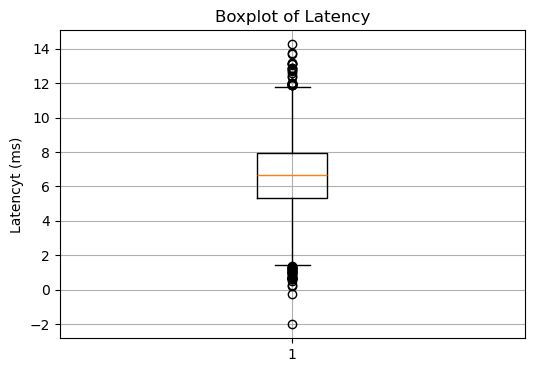

In [ ]:
# Boxplot of Latency
fig, ax = plt.subplots(figsize=(6,4))
ax.boxplot(merged_df['latency_ms'])
ax.set_title('Boxplot of Latency')
ax.set_ylabel('Latencyt (ms)')
ax.grid(True)

Text(0, 0.5, 'Average Latency (ms)')

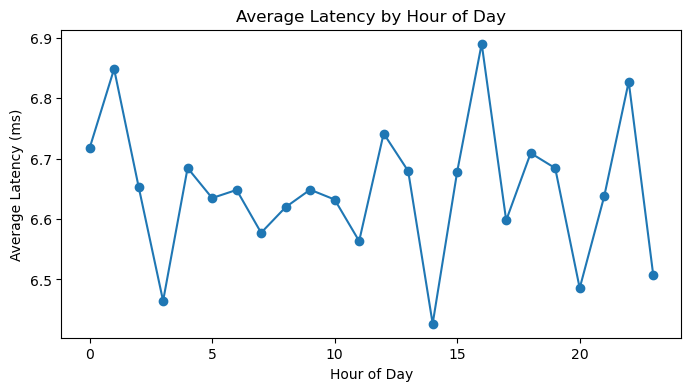

In [29]:
# Latency Over Time Plot
avg_by_hour = merged_df.groupby('hour')['latency_ms'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(avg_by_hour.index, avg_by_hour.values, marker='o')
ax.set_title('Average Latency by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Average Latency (ms)')


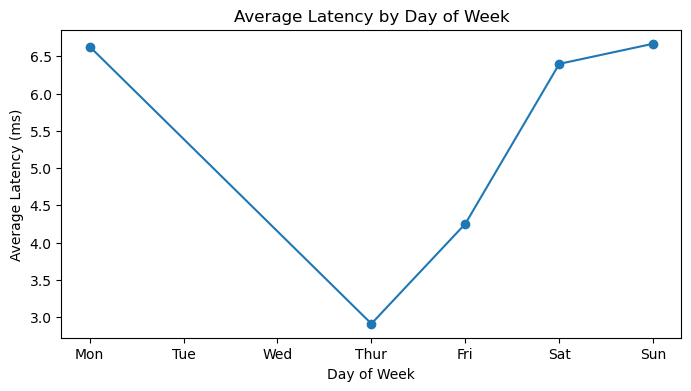

In [ ]:
avg_by_day = merged_df.groupby('day_of_week')['latency_ms'].mean()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(avg_by_day.index, avg_by_day.values, marker='o')
ax.set_title('Average Latency by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Average Latency (ms)')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

# Weekday ops might reduce load by Thursday
# Weekends have higher latency, maybe due to network conditions, user activity, or satellite pass timing
# Cyclical weekly pattern worth modeling
# If this holds over several weeks, potentially add day of week as a key feature in model,
    # investigate satellite ops vs days of the week
    # consider periodicity component if I use time-series models

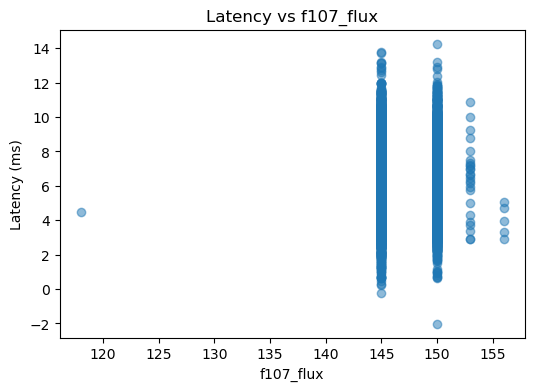

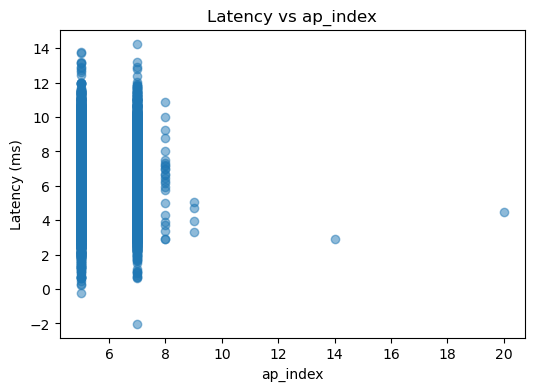

In [37]:
# Latency vs Solar Weather Variables
solar_vars = ['f107_flux', 'ap_index']
for var in solar_vars:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(merged_df[var], merged_df['latency_ms'], alpha=0.5)
    ax.set_title(f'Latency vs {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Latency (ms)')
    